In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
from collections import abc

import numpy as np
from matplotlib import pyplot as plt

from harmonic_balance import arclength_continuation as alc
from harmonic_balance import pseudo_arclength_continuation as plc
from harmonic_balance import freq, solve

ndarray = np.ndarray

## Define nonlinear force

In [ ]:
def get_slice(dof: int, N: int):
    return np.s_[dof * N : (dof + 1) * N]


def get_nonlinear(
    factor: float,
) -> tuple[
    abc.Callable[[ndarray, ndarray, int], ndarray],
    abc.Callable[[ndarray, ndarray, int], ndarray],
    abc.Callable[[ndarray, ndarray, int], ndarray],
]:
    dof = 0
    s_ = lambda N: get_slice(dof, N)

    def f_nl(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        res = np.zeros_like(x, dtype=float)
        res[s_(N)] += factor * x[s_(N)] ** 3
        return res

    def df_nl_dx(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        res = np.zeros_like(x, dtype=float)
        res[s_(N)] += factor * 3 * x[s_(N)] ** 2
        return np.diag(res)

    def df_nl_d_xdot(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        shape = x.shape[0]
        return np.zeros((shape, shape), dtype=float)

    return f_nl, df_nl_dx, df_nl_d_xdot

## Define system

In [ ]:
n = 2

m1, m2 = 1, 2
c1, c2, c3 = 1, 0.5, 2
k1, k2, k3 = 1, 0.5, 2

M = np.diag([m1, m2])
C = np.array([[c1 + c2, -c2], [-c2, c2 + c3]])
K = np.array([[k1 + k2, -k2], [-k2, k2 + k3]])

ks = (1, 1)
dofs = (0, 1)
is_cosines = (1, 0)
coefficients = (2, 1)

factor = 10
f_nl, df_nl_dx, df_nl_d_xdot = get_nonlinear(factor)

## Set harmonic balance parameters

In [ ]:
NH = 30
N = 128

b_ext = freq.get_b_ext(NH, n, ks, dofs, is_cosines, coefficients)

## Run harmonic balance

In [ ]:
s = 0.05

tol = 1e-11
max_iter = 100

omega_i0 = 2
A_i0 = freq.get_A(omega_i0, NH, M, C, K)
initial_guess = freq.solve_linear_system(A_i0, b_ext)
z_i0, *_ = solve.solve_nonlinear(
    omega_i0,
    initial_guess,
    A_i0,
    b_ext,
    f_nl,
    df_nl_dx,
    df_nl_d_xdot,
    NH,
    n,
    N,
    tol,
    max_iter=max_iter,
)

omega_i1 = omega_i0 + s
A_i1 = freq.get_A(omega_i1, NH, M, C, K)
initial_guess = freq.solve_linear_system(A_i1, b_ext)
z_i1, *_ = solve.solve_nonlinear(
    omega_i1,
    initial_guess,
    A_i1,
    b_ext,
    f_nl,
    df_nl_dx,
    df_nl_d_xdot,
    NH,
    n,
    N,
    tol,
    max_iter=max_iter,
)

## Run arclength continuation

In [ ]:
alc_tol = 1e-11
alc_max_iter = 50

y_i0 = np.concat((z_i0, [omega_i0]))
y_i1 = np.concat((z_i1, [omega_i1]))
y_i2_k0 = alc.predict_y(y_i1, y_i0, s)

y_i2, rhs, converged, iters = alc.correct_y(
    y_i2_k0,
    y_i1,
    b_ext,
    f_nl,
    df_nl_dx,
    df_nl_d_xdot,
    NH,
    n,
    N,
    s,
    M,
    C,
    K,
    alc_tol,
    alc_max_iter,
)

omega_i2, z_i2 = y_i2[-1].real, y_i2[:-1]

In [ ]:
print(f"norm(rhs) / norm(y_i2): {alc.get_rel_error(rhs, y_i2):.5e}")
print(f"iterations: {iters}")
print(f"norm(y_i2 - y_i1): {np.linalg.norm(y_i2 - y_i1):.15f}")
print(f"omega_i2: {omega_i2:.5f}")

norm(rhs) / norm(y_i2): 9.43749e-12
iterations: 40
norm(y_i2 - y_i1): 0.050000000001494
omega_i2: 2.09059


### Compute NLFR curve

In [ ]:
omega_i0 = 0.1

num_points = 200
s = 0.05
tol = 1e-6
max_iter = 100

ys, rel_errors, convergeds, iters = alc.compute_nlfr_curve(
    num_points,
    omega_i0,
    b_ext,
    f_nl,
    df_nl_dx,
    df_nl_d_xdot,
    NH,
    n,
    N,
    s,
    M,
    C,
    K,
    tol,
    max_iter,
)

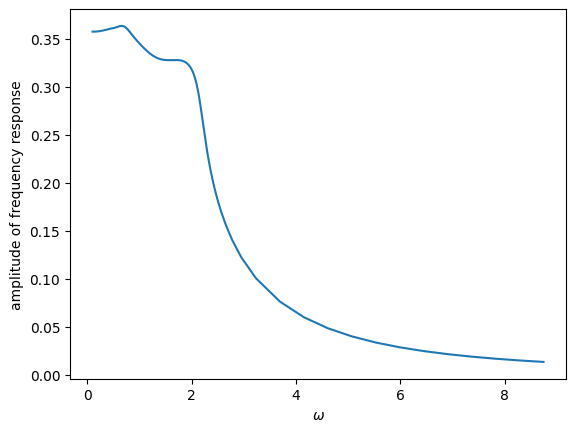

In [ ]:
amplitudes = np.linalg.norm(ys[:, :-1], axis=1)
omegas = ys[:, -1].real

fig, ax = plt.subplots(1, 1)

ax.plot(omegas, amplitudes)
ax.set_xlabel("$\omega$")
ax.set_ylabel("amplitude of frequency response")

plt.show()

## Run pseudo-arclength continuation

In [ ]:
plc_tol = 1e-11
plc_max_iter = 60

y_i0 = np.concat((z_i0, [omega_i0]))
y_i1 = np.concat((z_i1, [omega_i1]))

V = y_i1 - y_i0
V /= np.linalg.norm(V)
y_i2_k0 = alc.predict_y(y_i1, V, s)

y_i2, rhs, converged, iters = plc.correct_y(
    y_i2_k0,
    V,
    b_ext,
    f_nl,
    df_nl_dx,
    df_nl_d_xdot,
    NH,
    n,
    N,
    M,
    C,
    K,
    plc_tol,
    plc_max_iter,
)

omega_i2, z_i2 = y_i2[-1].real, y_i2[:-1]

In [ ]:
b_nl = solve.get_b_nl(z_i2, omega_i2, f_nl, NH, n, N)
print(
    f"norm(rhs) / norm(b_nl + b_ext): {plc.get_rel_error(rhs, b_nl + b_ext):.5e}"
)
print(f"iterations: {iters}")
print(f"norm(y_i2 - y_i1): {np.linalg.norm(y_i2 - y_i1):.15f}")
print(f"omega_i2: {omega_i2:.5f}")

norm(rhs) / norm(b_nl + b_ext): 4.67284e-04
iterations: 60
norm(y_i2 - y_i1): 0.058294962026844
omega_i2: 2.09730


### Compute NLFR curve

In [ ]:
omega_i0 = 0.1

num_points = 200
s = 0.05
tol = 1e-4
max_iter = 60

ys, rel_errors, convergeds, iters = plc.compute_nlfr_curve(
    num_points,
    omega_i0,
    b_ext,
    f_nl,
    df_nl_dx,
    df_nl_d_xdot,
    NH,
    n,
    N,
    s,
    M,
    C,
    K,
    tol,
    max_iter,
)

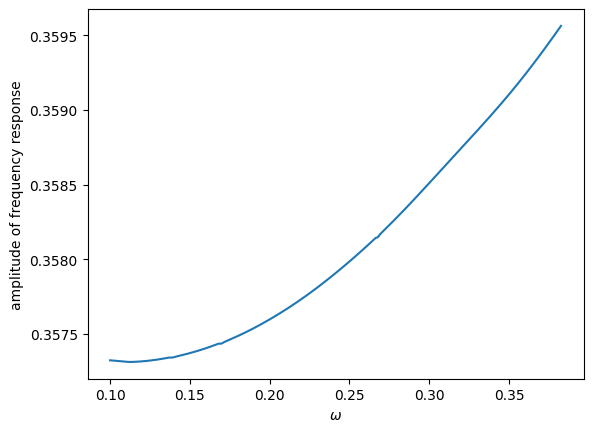

In [ ]:
amplitudes = np.linalg.norm(ys[:, :-1], axis=1)
omegas = ys[:, -1].real

fig, ax = plt.subplots(1, 1)

isinf = np.isinf(omegas) | np.isinf(amplitudes) | (omegas > 1e2)
ax.plot(omegas[~isinf], amplitudes[~isinf])#, marker="o")

ax.set_xlabel("$\omega$")
ax.set_ylabel("amplitude of frequency response")

plt.show()

In [ ]:
iters

array([12, 12,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2])

In [ ]:
np.diff(omegas)

array([0.01153846, 0.00251906, 0.00251291, 0.00251261, 0.0025136 ,
       0.00251513, 0.00251702, 0.00251924, 0.00252172, 0.00252443,
       0.00252732, 0.00252542, 0.00190237, 0.00190203, 0.00190354,
       0.00190533, 0.00190717, 0.00190901, 0.00191084, 0.00191266,
       0.00191446, 0.00191623, 0.00191797, 0.00191968, 0.00192136,
       0.001923  , 0.00192459, 0.00192315, 0.00144718, 0.00144665,
       0.0014473 , 0.00144807, 0.00144884, 0.0014496 , 0.00145034,
       0.00145107, 0.00145177, 0.00145245, 0.00145312, 0.00145377,
       0.00145439, 0.001455  , 0.00145559, 0.00145617, 0.00145672,
       0.00145726, 0.00145779, 0.00145829, 0.00145879, 0.00145926,
       0.00145973, 0.00146018, 0.00146062, 0.00146104, 0.00146145,
       0.00146185, 0.00146223, 0.0014626 , 0.00146296, 0.0014633 ,
       0.00146363, 0.00146395, 0.00146425, 0.00146454, 0.00146481,
       0.00146507, 0.00146532, 0.00146556, 0.00146579, 0.001466  ,
       0.00146621, 0.0014664 , 0.00146659, 0.00146678, 0.00146

In [ ]:
rel_errors

array([1.15584106e-05, 1.23549643e-05, 6.17692844e-05, 7.35818362e-05,
       7.73896682e-05, 8.01640612e-05, 8.29954532e-05, 8.60073739e-05,
       8.91675706e-05, 9.24232271e-05, 9.57244122e-05, 9.90283791e-05,
       5.39601972e-05, 7.30246883e-05, 7.96422616e-05, 8.22680640e-05,
       8.41195186e-05, 8.57947004e-05, 8.73989445e-05, 8.89500113e-05,
       9.04506324e-05, 9.19013399e-05, 9.33026887e-05, 9.46555832e-05,
       9.59612515e-05, 9.72211475e-05, 9.84368402e-05, 9.96099171e-05,
       5.30629201e-05, 6.95707197e-05, 7.56689602e-05, 7.72886335e-05,
       7.80443997e-05, 7.86309706e-05, 7.91753502e-05, 7.97009378e-05,
       8.02124516e-05, 8.07112740e-05, 8.11982119e-05, 8.16739824e-05,
       8.21392837e-05, 8.25947899e-05, 8.30411315e-05, 8.34788750e-05,
       8.39085059e-05, 8.43304162e-05, 8.47448993e-05, 8.51521513e-05,
       8.55522807e-05, 8.59453237e-05, 8.63312661e-05, 8.67100686e-05,
       8.70816956e-05, 8.74461429e-05, 8.78034651e-05, 8.81537987e-05,
      